# packages

In [ ]:
!pip install dionysus
!pip install ripser
!pip install script

ERROR: Could not find a version that satisfies the requirement script (from versions: none)
ERROR: No matching distribution found for script


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
import random

def minmax_subsample(pts, n, seed=3):
    '''
    Subsample points using greedy permutation algorithm.

    Parameters
    ----------
    pts: np.array
        Points in point cloud.
    n: int
        Number of points to subsample (default is None, meaning no subsampling)
    seed: int
        Seed for random generation of starting point

    '''

    # Get pairwise distance matrix of all points
    D = pairwise_distances(pts, metric='euclidean')

    # Initialize array for subsampled points
    newpts = np.zeros((n,2))

    # Pick a random starting point and add it to array
    st = random.randint(0,len(pts)-1)
    newpts[0,:]= pts[st,:]

    # Only look at distances from starting point
    ds = D[st,:]
    for i in range(1,n):

        # Find point furthest away
        idx = np.argmax(ds)

        newpts[i,:] = pts[idx,:]

        ds = np.minimum(ds, D[idx, :])

    return newpts

def time_delay_embedding(ts, d=2, tau=1):
    '''
    Compute delay embedding

    Parameters
    ----------
    ts: list or np.array
        Time series values
    d: int
        Dimension for delay embedding
    tau: int
        Delay for delay embedding

    '''
    numpts = len(ts) - tau * (d-1)

    pts = [[ts[i+(j*tau)] for j in range(d) ] for i in range(numpts)]

    return np.array(pts)


In [ ]:
import numpy as np
import dionysus as dio
import pandas as pd
import matplotlib.pyplot as plt
import time
from ripser import ripser
import warnings




class PtClouds(object):
    '''
    Class to hold collection of point clouds.

    Parameters
    ----------
    ptclouds: list
        List of point clouds
    cplx_type: string (not case sensitive)
        Type of complex you want to use. Options are Rips or Landmark (default is Rips)
    num_landmarks: int
        Number of points to subsample (default is None, meaning no subsampling)
    verbose: bool
        If true, prints updates when running code (default is False)

    '''

    def __init__(self, ptclouds, cplx_type='rips', num_landmarks=None, verbose=False):
        '''
        Initialize.

        '''

        if isinstance(ptclouds, pd.DataFrame):
            self.ptclouds_full = ptclouds
        else:
            self.ptclouds_full = pd.DataFrame(columns=['PtCloud'])
            self.ptclouds_full['PtCloud'] = ptclouds

        self.use_Landmarks(num_landmarks = num_landmarks)

        self.num_landmarks = num_landmarks

        if cplx_type.lower() not in ['rips', 'landmark']:
            warnings.warn("Complex type not recognized. Setting to rips by default.")
            self.cplx_type = 'rips'
        else:
            self.cplx_type = cplx_type.lower()

        self.verbose = verbose

    def __str__(self):
        '''
        Nicely prints.

        '''
        attrs = vars(self)
        output = ''
        output += 'Point Cloud\n'
        output += '---\n'
        for key in attrs.keys():
            output += str(key) + ' : '
            output += str(attrs[key])+ '\n'
        output += '---\n'
        return output

    def use_Landmarks(self, num_landmarks = None):
        '''
        Uses landmark complex by subsampling each point cloud using a max min approach.

        Parameters
        ----------

        num_landmarks: int
            Number of points to subsample (default is None, meaning no subsampling)
        '''

        # No subsampling, use full point clouds
        if num_landmarks == None:
            self.ptclouds = self.ptclouds_full
            return

        # Subsample num_landmarks points from each point cloud using MinMax approach
        self.ptclouds = pd.DataFrame(columns=['PtCloud'])
        for i, pc in enumerate(self.ptclouds_full['PtCloud']):
            self.ptclouds.loc[i,'PtCloud'] = minmax_subsample(pc, num_landmarks, seed=None)


    def run_Zigzag(self, r, k=2):
        '''
        Runs zigzag persistence on collections of point clouds, taking unions between each adjacent pair of point clouds.
        Adds attributes to class ``zz``, ``zz_dgms``, ``zz_cells`` which are the outputs of dionysus' zigzag persistence function.
        Also adds attributes ``setup_time`` and ``zigzag_time`` with timing data.

        Parameters
        ----------

        r: float or list of floats,
            Parameter for Rips complex on each point cloud. Can be a single number or a list with one value per point cloud.
        k: int, optional
            Maximum dimension simplex desired (default is 2)

        '''

        if k > 2:
            print('Oops, k>2 is not implemented. Setting back to 2.')
            self.k = 2
        else:
            self.k = k

        # Type check r and see if need to use fixed or changing radius
        if type(r) == list:
            # if there's only one entry in the list, only need fixed radius version
            if len(set(r)) == 1:
                self.r = r[0]
            # if it's a list, keep all and use changing radius versionn
            else:
                self.r = r
        elif type(r) == int or type(r) == float:
            self.r = r
        else:
            warnings.warn("Input for r is invalid. Retry with list, int or float")
            return

        ft_st = time.time()

        # Set up inputs for dionysus zigzag persistence
        if type(self.r) == float or type(self.r) == int:
            filtration, times = self.setup_Zigzag_fixed(r = self.r, k = self.k, verbose = self.verbose)
        else:
            filtration, times = self.setup_Zigzag_changing(r = self.r, k = self.k, verbose = self.verbose)

        self.filtration = filtration
        self.times_list = times

        ft_end = time.time()
        if self.verbose:
            print('Time to build filtration, times: ', str(ft_end-ft_st))

        # Run zigzag presistence using dionysus
        zz_st = time.time()
        zz, dgms, cells = dio.zigzag_homology_persistence(self.filtration,self.times_list)
        zz_end = time.time()

        if self.verbose:
            print('Time to compute zigzag: ', str(zz_end-zz_st))
            print('Total Time: ', str(zz_end - ft_st), '\n')

        dgms = [ np.array([ [p.birth,p.death] for p in dgm]) for dgm in dgms ]

        self.zz = zz
        self.zz_dgms = dgms[0:k] # only keep appropriate dimensions
        self.zz_cells = cells

        self.setup_time = ft_end - ft_st
        self.zigzag_time = zz_end - zz_st



    def setup_Zigzag_fixed(self, r, k=2, verbose=False):
        '''
        Helper function for ``run_Zigzag`` that sets up inputs needed for Dionysus' zigzag persistence function.
        This only works for a fixed radius r.

        Parameters
        ----------

        r: float
            Radius for rips complex

        k: int, optional
            Max dimension for rips complex (default is 2)

        verbose: bool, optional
            If true, prints updates when running code

        Returns
        -------
        filtration: dio.Filtration
            Dionysis filtration containing all simplices that exist in zigzag sequence

        times: list
            List of times, where times[i] is a list containing [a,b] where simplex i appears at time a, and disappears at time b

        '''

        lst = list(self.ptclouds['PtCloud'])

        # simps_df = pd.DataFrame(columns = ['Simp','B,D'])
        simps_list = []; times_list = []

        # Vertex counter
        vertind = 0

        init_st = time.time()
        # Initialize A with R(X_0)
        rips = dio.fill_rips(lst[0], k=2, r=r)
        rips.sort()
        rips_set = set(rips)

        # Initialize A with set of simplices with verts in X_0
        A = rips_set

        # # Add all simps to the list with birth,death=[0,1]
        simps_list =  simps_list + [s for s in A]
        times_list = times_list + [[0,1] for j in range(len(A))]

        # Initialize with vertices for X_0
        verts = set([dio.Simplex([j+vertind],0) for j,pc in enumerate(lst[0])])

        init_end = time.time()
        if verbose:
            print(f'Initializing done in {init_end-init_st} seconds...')

        loop_st = time.time()
        # Loop over the rest of the point clouds
        for i in range(1,len(lst)):

            # Calculate rips of X_{i-1} \cup X_i
            rips = dio.fill_rips(np.vstack([lst[i-1],lst[i]]), k=2, r=r)

            # Adjust vertex numbers, sort, and make into a set
            rips = fix_dio_vert_nums(rips, vertind)
            rips.sort()
            rips_set = set(rips)

            # Increment vertex counter
            vertind = vertind+len(verts)

            # Set of vertices in R(X_i)
            verts_next = set([dio.Simplex([j+vertind],0) for j,pc in enumerate(lst[i])])

            # Set of simplices with verts in X_{i}
            B = set(verts_next.intersection(rips_set))

            # Set of simplices with verts in X_{i-1} AND X_{i}
            M = set()

            # Loop over vertices in R(X_{i-1} \cup R_i)
            for simp in rips:

                # Get list of vertices of simp
                bdy = get_verts(simp)

                # If it has no boundary and its in B, its a vertex in B and has been handled
                if not bdy:
                    continue

                # If all of its verts are in A, it's been handled in the initialization or the previous iteration
                if bdy.intersection(A) == bdy:
                    continue

                # If all of its verts are in B, add it to B
                elif bdy.intersection(B) == bdy:
                    B.add(simp)

                # If it has some verts in A and some in B, it only exists in the union
                # Add it to M
                else:
                    M.add(simp)


            # Add simplices in B with the corresponding birth,death times
            simps_list = simps_list + [s for s in B]
            times_list = times_list + [ [i-0.5,i+1] for j in range(len(B)) ]

            # Add simplicies in M with corresponding birth,death times
            simps_list = simps_list + [s for s in M]
            times_list = times_list + [ [i-0.5,i] for j in range(len(M)) ]

            # Reinitialize for next iteration
            verts = verts_next
            A = B

        loop_end = time.time()
        if verbose:
            print(f'Preprocessing done in {loop_end-loop_st} seconds...')

        f_st = time.time()
        filtration = dio.Filtration(simps_list)
        f_end = time.time()

        return filtration, times_list


    def setup_Zigzag_changing(self, r, k=2, verbose=False):
        '''
        Helper function for ``run_Zigzag`` that sets up inputs needed for Dionysus' zigzag persistence function.
        This one allows r to be a list of radii, rather than one fixed value

        Parameters
        ----------

        r: list
            List of radii for rips complex of each X_i

        k: int, optional
            Max dimension for rips complex (default is 2)

        verbose: bool, optional
            If true, prints updates when running code

        Returns
        -------
        filtration: dio.Filtration
            Dionysis filtration containing all simplices that exist in zigzag sequence

        times: list
            List of times, where times[i] is a list containing [a,b] where simplex i appears at time a, and disappears at time b

        '''

        lst = list(self.ptclouds['PtCloud'])

        # If you haven't input enough r values, just append extra of the last
        # list entry to make it the right number
        if len(r) < len(lst):
            if verbose:
                print('Warning: too few radii given, duplicating last entry')
            r = r + ([r[-1]]* (len(lst)- len(r)))
        elif len(r) > len(lst):
            if verbose:
                print('Warning: too many radii given, only using first ', len(lst))
            r = r[:len(lst)]
        self.r = r

        # simps_df = pd.DataFrame(columns = ['Simp','B,D'])
        simps_list = []; times_list = []

        # Vertex counter
        vertind = 0

        init_st = time.time()

        # Initialize A with R(X_0)
        rips = dio.fill_rips(lst[0], k=2, r=r[0])
        rips.sort()
        rips_set = set(rips)

        # Initialize A with set of simplices with verts in X_0
        # In the loop, this will store simplices with verts in X_{i-1}
        A = rips_set

        # Add all simps to the list with birth,death=[0,1]
        simps_list =  simps_list + [s for s in A]
        times_list = times_list + [[0,1] for j in range(len(A))]

        # Initialize with vertices for X_0
        # In the loop, this will store vertices in X_{i-1}
        verts = set([dio.Simplex([j+vertind],0) for j,pc in enumerate(lst[0])])

        init_end = time.time()
        if verbose:
            print(f'Initializing done in {init_end-init_st} seconds...')

        loop_st = time.time()
        # Loop over the rest of the point clouds
        for i in range(1,len(lst)):

            # Calculate rips of X_{i-1} \cup X_i
            rips = dio.fill_rips(np.vstack([lst[i-1],lst[i]]), k=2, r=max(r[i-1],r[i]))

            # Adjust vertex numbers, sort, and make into a set
            rips = fix_dio_vert_nums(rips, vertind)
            rips.sort()
            rips_set = set(rips)

            # Increment vertex counter
            vertind = vertind+len(verts)

            # Set of vertices in X_{i}
            verts_next = set([dio.Simplex([j+vertind],0) for j,pc in enumerate(lst[i])])

            # Set of simplices with verts in X_{i}
            B = set(verts_next.intersection(rips_set))

            # Set of simplices with verts in X_{i-1} AND X_{i}
            # And simplicies in X_{i-1} \cup X_{i} that are not in X_{i-1} or X_i
            M = set()

            # Loop over vertices in R(X_{i-1} \cup R_i)
            for simp in rips:

                # Get list of vertices of simp
                bdy = get_verts(simp) #set([s for s in simp.boundary()])

                # If it has no boundary and its in B, its a vertex in B and has been handled
                if not bdy:
                    continue

                # If all of its verts are in A, it's been handled in the initialization or the previous iteration
                if bdy.intersection(A) == bdy:
                    if r[i-1] < r[i]:
                        if simp.data > r[i-1]:
                            # If we haven't seen it before, add it to M
                            if simp not in simps_list:
                                M.add(simp)

                            # If we've already added it to the list...
                            else:
                                # Edit the lists to include new birth,death times
                                simps_list, times_list = edit_Simp_Times(simp,[i-0.5,i],simps_list,times_list)


                # If all of its verts are in B...
                elif bdy.intersection(B) == bdy:

                    # If r[i-1] <= r[i], anything with verts in B should also be in B
                    if r[i-1] <= r[i]:
                        B.add(simp)

                    # If r[i-1] > r[i], we need to check if it should go in M or B
                    else:
                        # If simplex's birth time is greater than the radius, it goes in M
                        if simp.data > r[i]:
                            M.add(simp)

                        # If it's <= then it goes in B
                        else:
                            B.add(simp)

                # If it has some verts in A and some in B, it only exists in the union
                else:
                    # If we haven't seen it before, add it to M
                    if simp not in simps_list:
                        M.add(simp)

                    # If we've already added it to the list...
                    else:
                        # Edit the lists to include new birth,death times
                        simps_list, times_list = edit_Simp_Times(simp,[i-0.5,i],simps_list,times_list)


            # Add simps and times that are in B
            simps_list = simps_list + [simp for simp in B]
            times_list = times_list + [[i-0.5,i+1] for j in range(len(B))]

            # Add simps and times that are in M
            simps_list = simps_list + [simp for simp in M]
            times_list = times_list + [[i-0.5,i] for j in range(len(M))]

            # Reinitialize for next iteration
            verts = verts_next
            A = B

        loop_end = time.time()
        if verbose:
            print(f'Preprocessing done in {loop_end-loop_st} seconds...')

        # Put list of simplices into Filtration format
        filtration = dio.Filtration(simps_list)

        return filtration, times_list



    def plot_ZZ_PtClouds(self, save=False, savename='PC.png', v_plts=None, h_plts=None):
        '''
        Plot the zigzag of point clouds.

        Parameters
        ----------
        save: bool
            Set to true if you want to save the figure (default is False)

        savename: string
            Path to save figure (default is 'PC.png' in current directory)

        v_plts: int
            Number of plots in vertical direction

        h_plts: int
            Number of plots in horizontal direction

        '''

        if not hasattr(self,'ptclouds'):
            print('No point clouds found...')
            print('Quitting...')
            return

        PC_list = list(self.ptclouds['PtCloud'])
        All_PC = np.vstack(PC_list)

        xmin = min(All_PC[:,0]) - 0.5 #0.1*min(All_PC[:,0])
        xmax = max(All_PC[:,0]) + 0.5 #0.1*max(All_PC[:,0])

        ymin = min(All_PC[:,1]) - 0.5 #0.1*min(All_PC[:,1])
        ymax = max(All_PC[:,1]) + 0.5 #0.1*max(All_PC[:,1])

#         plt.rcParams.update({'font.size': 18})

        if h_plts is not None:
            v_plts = int(np.ceil( (2*len(PC_list)-1)/ h_plts ))
        elif v_plts is not None:
            h_plts = int(np.ceil( (2*len(PC_list)-1)/ v_plts ))
        else:
            v_plts = int(np.ceil( (2*len(PC_list)-1)/ 8 ))
            h_plts = 8

        fig, axs = plt.subplots(v_plts, h_plts, sharex=True, sharey=True, figsize=[h_plts*2.5,v_plts*3])
        axs = axs.ravel()

        # Make color list
        cs = plt.rcParams['axes.prop_cycle'].by_key()['color']

        # Make sure color list is long enough
        if len(PC_list) > 10:
            cs = cs * int(np.ceil(len(PC_list)/10))

        # Plotting...
        for i,ax in enumerate(axs):

            if i >= 2*len(PC_list)-1:
                ax.axis('off')
                continue

            # Plot point clouds alone
            if i%2==0:
                ax.scatter(PC_list[int(i/2)][:,0], PC_list[int(i/2)][:,1], c=cs[int(i/2)])
                ax.set_title( '$X_{'+str(int(i/2))+'}$' ) #int(i/2))
                ax.set_xlim([xmin,xmax])
                ax.set_ylim([ymin,ymax])

            # Plot union of point clouds
            else:
                ax.scatter(PC_list[int((i-1)/2)][:,0], PC_list[int((i-1)/2)][:,1], c=cs[int((i-1)/2)])
                ax.scatter(PC_list[int((i+1)/2)][:,0], PC_list[int((i+1)/2)][:,1], c=cs[int((i+1)/2)])
                ax.set_title( '$X_{'+str(int((i-1)/2))+'} \cup X_{' + str(int((i+1)/2)) + '}$' )
                ax.set_xlim([xmin,xmax])
                ax.set_ylim([ymin,ymax])

        plt.tight_layout() #pad=2.0)

        # Save figure
        if save:
            print('Saving fig at ', savename, '...')
            plt.savefig(savename, dpi=500, bbox_inches='tight')


    def plot_ZZ_Full_PtClouds(self, save=False, savename='PC_Full.png', v_plts=None, h_plts=None):
        '''
        Plot the zigzag of full point clouds.
        Only needed if using landmark complex and want to plot the full point clouds before subsampling.

        Parameters
        ----------
        save: bool
            Set to true if you want to save the figure (default is False)

        savename: string
            Path to save figure (default is 'PC_Full.png' in current directory)

        v_plts: int
            Number of plots in vertical direction

        h_plts: int
            Number of plots in horizontal direction

        '''

        if not hasattr(self,'ptclouds_full'):
            print('No point clouds found...')
            print('Quitting...')
            return

        PC_list = list(self.ptclouds_full['PtCloud'])
        All_PC = np.vstack(PC_list)

        xmin = min(All_PC[:,0]) - 0.5
        xmax = max(All_PC[:,0]) + 0.5

        ymin = min(All_PC[:,1]) - 0.5
        ymax = max(All_PC[:,1]) + 0.5

#         plt.rcParams.update({'font.size': 18})

        if h_plts is not None:
            v_plts = int(np.ceil( (2*len(PC_list)-1)/ h_plts ))
        elif v_plts is not None:
            h_plts = int(np.ceil( (2*len(PC_list)-1)/ v_plts ))
        else:
            v_plts = int(np.ceil( (2*len(PC_list)-1)/ 8 ))
            h_plts = 8

        fig, axs = plt.subplots(v_plts, h_plts ,sharey=True, sharex=True,figsize=[h_plts*2.5,v_plts*3])
        axs = axs.ravel()

        # Make color list
        cs = plt.rcParams['axes.prop_cycle'].by_key()['color']

        # Make sure color list is long enough
        if len(PC_list) > 10:
            cs = cs * int(np.ceil(len(PC_list)/10))

        # Plotting...
        for i,ax in enumerate(axs):
            if i >= 2*len(PC_list)-1:
                ax.axis('off')
                continue

            # Plot point clouds alone
            if i%2==0:
                ax.scatter(PC_list[int(i/2)][:,0], PC_list[int(i/2)][:,1], c=cs[int(i/2)])
                ax.set_title( f'$X_{str(int(i/2))}$' ) #int(i/2))
                ax.set_xlim([xmin,xmax])
                ax.set_ylim([ymin,ymax])

            # Plot union of point clouds
            else:
                ax.scatter(PC_list[int((i-1)/2)][:,0], PC_list[int((i-1)/2)][:,1], c=cs[int((i-1)/2)])
                ax.scatter(PC_list[int((i+1)/2)][:,0], PC_list[int((i+1)/2)][:,1], c=cs[int((i+1)/2)])
                ax.set_title( f'$X_{str(int((i-1)/2))} \cup X_{str(int((i+1)/2))}$' )
                ax.set_xlim([xmin,xmax])
                ax.set_ylim([ymin,ymax])

        plt.tight_layout()

        # Save figure
        if save:
            print('Saving fig at ', savename, '...')
            plt.savefig(savename, dpi=500, bbox_inches='tight')


    def plot_ZZ_Cplx(self, save=False, savename='/content/Cplx.png', v_plts=None, h_plts=None,r=None):
        '''
        Plot the zigzag of rips complexes.

        Parameters
        ----------
        save: bool
            Set to true if you want to save the figure (default is False)

        savename: string
            Path to save figure (default is 'Cplx.png' in current directory)

        v_plts: int
            Number of plots in vertical direction

        h_plts: int
            Number of plots in horizontal direction

        '''

        if not hasattr(self,'filtration'):
            print('No filtration calculated yet...')
            print('Use run_Zigzag first then you can use this function...')
            print('Quitting...')
            return

        PC_list = list(self.ptclouds['PtCloud'])
        All_PC = np.vstack(PC_list)

        if type(self.r) != list:
            r_plot = [self.r]*(2*len(PC_list)-1)
        else:
            r_plot = self.r

        xmin = min(All_PC[:,0]) - 0.5
        xmax = max(All_PC[:,0]) + 0.5

        ymin = min(All_PC[:,1]) - 0.5
        ymax = max(All_PC[:,1]) + 0.5

#         plt.rcParams.update({'font.size': 18})

        if h_plts is not None:
            v_plts = int(np.ceil( (2*len(PC_list)-1)/ h_plts ))
        elif v_plts is not None:
            h_plts = int(np.ceil( (2*len(PC_list)-1)/ v_plts ))
        else:
            v_plts = int(np.ceil( (2*len(PC_list)-1)/ 8 ))
            h_plts = 8

        fig, axs = plt.subplots(v_plts, h_plts ,sharey=True, sharex=True, figsize=[h_plts*2.5,v_plts*3])
        axs = axs.ravel()

        # Make color list
        cs = plt.rcParams['axes.prop_cycle'].by_key()['color']

        # Make sure color list is long enough
        if len(PC_list) > 10:
            cs = cs * (int(np.ceil(len(PC_list)/10)) +1)

        # Plotting vertices
        for i,ax in enumerate(axs):

            if i >= 2*len(PC_list)-1:
                ax.axis('off')
                continue

            # Plot point clouds alone
            if i%2==0:
                ax.scatter(PC_list[int(i/2)][:,0], PC_list[int(i/2)][:,1], c=cs[int(i/2)])
                if self.cplx_type == 'rips' or self.cplx_type == 'landmark':
                  if r:
                    ax.set_title( '$R(X_{' + str(int(i/2) if int(i/2)<2 else int(i/2)-2)+ '},r='+str(r)+')$' )
                  else:
                    ax.set_title( '$R(X_{' + str(int(i/2) if int(i/2)<2 else int(i/2)-2)+ '})$' )#',' +str(r_plot[int(i/2)])+ ')$' )
                    #ax.set_title( '$R(X_{' + str(int(i/2))+ '})$' )#',' +str(r_plot[int(i/2)])+ ')$' )
                elif self.cplx_type == 'witness':
                    ax.set_title( f'$W(X_{str(int(i/2))})$' )
                ax.set_xlim([xmin,xmax])
                ax.set_ylim([ymin,ymax])

            # Plot union of point clouds
            else:
                ax.scatter(PC_list[int((i-1)/2)][:,0], PC_list[int((i-1)/2)][:,1], c=cs[int((i-1)/2)])
                ax.scatter(PC_list[int((i+1)/2)][:,0], PC_list[int((i+1)/2)][:,1], c=cs[int((i+1)/2)])
                if self.cplx_type == 'rips' or self.cplx_type == 'landmark':
                    if r:
                      ax.set_title('$R(X_{' + str(int((i-1)/2) if int((i-1)/2)<2 else int((i-1)/2)-2) + '} \cup X_{' + str(int((i+1)/2) if int((i+1)/2)<2 else int((i+1)/2)-2)+ '},r='+str(r)+')$' )# ', '+ str(max(r_plot[int((i-1)/2)], r_plot[int((i+1)/2)])) + ')$' )
                    else:
                      #ax.set_title('$R(X_{' + str(int((i-1)/2)) + '} \cup X_{' + str(int((i+1)/2))+ '})$' )# ', '+ str(max(r_plot[int((i-1)/2)], r_plot[int((i+1)/2)])) + ')$' )
                      ax.set_title('$R(X_{' + str(int((i-1)/2) if int((i-1)/2)<2 else int((i-1)/2)-2) + '} \cup X_{' + str(int((i+1)/2) if int((i+1)/2)<2 else int((i+1)/2)-2)+ '})$' )# ', '+ str(max(r_plot[int((i-1)/2)], r_plot[int((i+1)/2)])) + ')$' )

                elif self.cplx_type == 'witness':
                    ax.set_title( f'$W(X_{str(int((i-1)/2))} \cup X_{str(int((i+1)/2))})$' )
                ax.set_xlim([xmin,xmax])
                ax.set_ylim([ymin,ymax])


        # Plotting edges
        for i, s in enumerate(self.filtration):
            if s.dimension() == 1:
                vs = [v for v in s]
                ts = [int(t*2) for t in self.times_list[i]]
                for j in range(ts[0], ts[1]):
                    if j == int((2*len(PC_list)-1)):
                        break
                    else:
                        axs[j].plot( [All_PC[vs[0]][0], All_PC[vs[1]][0]], [All_PC[vs[0]][1], All_PC[vs[1]][1]], c='k' )

        plt.tight_layout()

        # Save figure
        if save:
            print('Saving fig at ', savename, '...')
            plt.savefig(savename, format='svg',dpi=500, bbox_inches='tight')



def edit_Simp_Times(simp,new_bd_times,simps_list,times_list):
    '''
    Helper function to adjust appearance/disappearance times of a particular simplex.

    Parameters
    ----------
    simp: dio.Simplex
        Simplex to modify time for
    new_bd_times: list
        New appearance and disappearance times
    simps_list: list
        Current list of simplices
    times_list: list of lists
        Current list of times lists

    Returns
    -------
    simps_list: list
        Updated list of simplices
    times_list: list of lists
        Updated list of times lists

    '''

    # Find where it is in the list
    simp_ind = simps_list.index(simp)

    # Remove the simplex and its birth,death time from each list
    simps_list.pop(simp_ind)
    curr_times = times_list.pop(simp_ind)

    # Add to lists and concatenate birth,death times we've added before with new ones
    simps_list.append(simp)
    times_list.append(curr_times + new_bd_times)

    return simps_list, times_list


def fix_dio_vert_nums(Cplx, vertind):
    '''
    Helper function to adjust indexing of vertices in Dionysus from ``fill_rips`` function.

    Cplx: List of dio.Simplex's or a dio.Filtration
        Starting complex you want to adjust indices of

    vertind: int
        Starting index for vertices

    Returns
    -------
    New complex with vertex indices adjusted by vertind.

    '''
    New_Cplx = []
    for s in Cplx:
        # s.data = data
        vlist = []
        for v in s:
            vlist.append(v+vertind)
        s = dio.Simplex(vlist,s.data)

        New_Cplx.append(s)
    return New_Cplx

def get_verts(simp):
    '''
    Helper function to get all vertices of the input simplex

    Parameters
    -----------
    simp: dio.Simplex
        Instance of Dionysus simplex class

    Returns
    -------
    List of vertices in the simplex

    '''
    if simp.dimension == 2:
        return [dio.Simplex([v],0) for v in t]
    else:
        return set([s for s in simp.boundary()])


# Input text

In [ ]:
# Sentences

#ex1 r=0.5

english_sentence = "You're completely useless; you can't do anything right anything do can't you useless completely you're"
french_translation = "Tu as encore beaucoup à apprendre pour t'améliorer pour apprendre à beaucoup encore as Tu"

"""
english_sentence = "You're completely useless; you can't do anything right anything do can't you useless completely you're"
french_translation ="Tu es complètement inutile ; tu n'effectues jamais rien correctement rien jamais n'effectues tu inutile complètement es Tu"
"""
"""
#ex2 r=0.1
english_sentence = "You need to work on improving your skills"
french_translation = "Tes compétences sont lamentables il faut vraiment que tu te reprennes"
"""
"""
#ex3
english_sentence = "Russia is expanding in ukraine"
french_translation = "La Russie envahit brutalement l'Ukraine"
"""
"""
#ex4
english_sentence = "Russia is expanding in ukraine "
french_translation = "La Russie envahit brutalement l'Ukraine "
"""

#ex5
"""
english_sentence = "He is in a better place He is in a better place He is in a better place He is in a better place"
french_translation = "Il est mort Il est mort Il est mort Il est mort"
"""



'\nenglish_sentence = "He is in a better place He is in a better place He is in a better place He is in a better place"\nfrench_translation = "Il est mort Il est mort Il est mort Il est mort"\n'

# sentiment analysis

In [ ]:
from transformers import pipeline
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import nltk
import pandas as pd
import re
from scipy.interpolate import make_interp_spline
import numpy as np

In [ ]:
nltk.download('punkt_tab')  # Correct download


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# Initialize sentiment analysis pipeline
sentiment_analyzer = pipeline("sentiment-analysis")
print("Model name:", sentiment_analyzer.model.name_or_path)

# Tokenize sentences
english_tokens = word_tokenize(english_sentence)
french_tokens = word_tokenize(french_translation)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


Model name: distilbert/distilbert-base-uncased-finetuned-sst-2-english


In [ ]:
# Function to remove non-alphabetic tokens
def remove_non_alphabetic(tokens):
    return [token for token in tokens if re.match(r"^[a-zA-Z]+$", token)]

# Remove non-alphabetic tokens from both lists
english_tokens = remove_non_alphabetic(english_tokens)
french_tokens = remove_non_alphabetic(french_tokens)


In [ ]:
# Function to get sentiment score for each token
def get_sentiment_for_tokens(tokens):
    scores = []
    for token in tokens:
        # Perform sentiment analysis for each token (considering it as a word)
        result = sentiment_analyzer(token)[0]
        if result['label'] == 'POSITIVE':
            score = result['score']
        elif result['label'] == 'NEGATIVE':
            score = -result['score']
        scores.append(score)
    return scores

# Get sentiment scores for tokens in both sentences
english_scores = get_sentiment_for_tokens(english_tokens)
french_scores = get_sentiment_for_tokens(french_tokens)


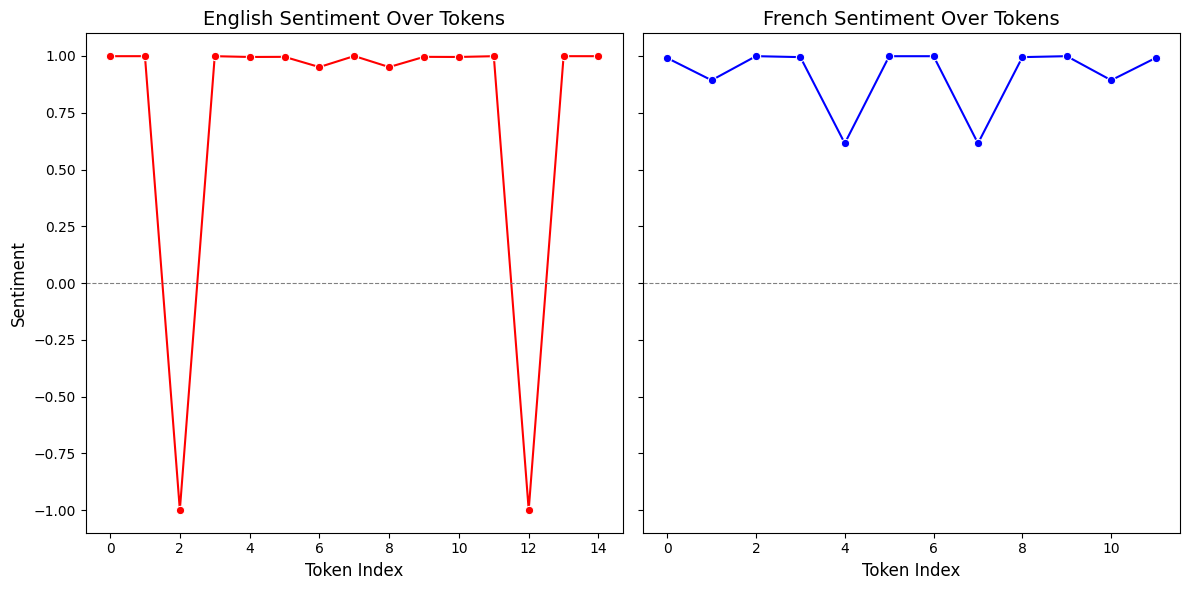

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create DataFrames with unique indices
df_english = pd.DataFrame({
    "Index": range(len(english_tokens)),
    "Tokens": english_tokens,
    "Sentiment": english_scores
})

df_french = pd.DataFrame({
    "Index": range(len(french_tokens)),
    "Tokens": french_tokens,
    "Sentiment": french_scores
})

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Plot English Sentiment
sns.lineplot(ax=axes[0], data=df_english, x="Index", y="Sentiment", marker="o", color="red")
axes[0].set_title("English Sentiment Over Tokens", fontsize=14)
axes[0].set_xlabel("Token Index", fontsize=12)
axes[0].set_ylabel("Sentiment", fontsize=12)
axes[0].axhline(0, color='gray', linestyle='--', linewidth=0.8)

# Plot French Sentiment
sns.lineplot(ax=axes[1], data=df_french, x="Index", y="Sentiment", marker="o", color="blue")
axes[1].set_title("French Sentiment Over Tokens", fontsize=14)
axes[1].set_xlabel("Token Index", fontsize=12)
axes[1].axhline(0, color='gray', linestyle='--', linewidth=0.8)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


# Curve fitting

In [ ]:
# Create separate DataFrames
df_english = pd.DataFrame({
    "Tokens": english_tokens,
    "Sentiment": english_scores
})

df_french = pd.DataFrame({
    "Tokens": french_tokens,
    "Sentiment": french_scores
})

# Perform interpolation for English
x_english = np.arange(len(english_tokens))
x_english_smooth = np.linspace(x_english.min(), x_english.max(), 300)
y_english_smooth = make_interp_spline(x_english, english_scores)(x_english_smooth)

# Perform interpolation for French
x_french = np.arange(len(french_tokens))
x_french_smooth = np.linspace(x_french.min(), x_french.max(), 300)
y_french_smooth = make_interp_spline(x_french, french_scores)(x_french_smooth)


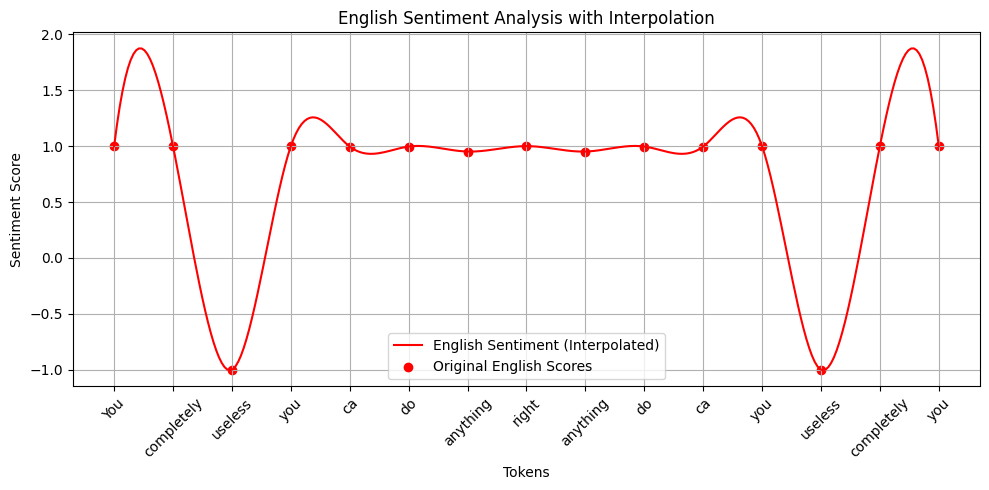

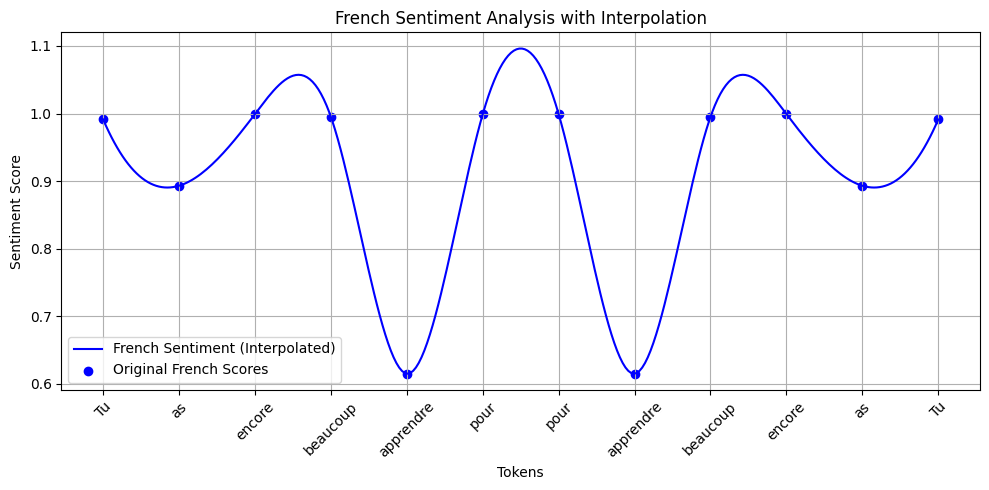

In [ ]:

# Plot the English sentiment scores with interpolation
plt.figure(figsize=(10, 5))
plt.plot(x_english_smooth, y_english_smooth, color='red', label="English Sentiment (Interpolated)")
plt.scatter(x_english, english_scores, color='red', label="Original English Scores", marker='o')
plt.title("English Sentiment Analysis with Interpolation")
plt.xlabel("Tokens")
plt.ylabel("Sentiment Score")
plt.xticks(ticks=x_english, labels=english_tokens, rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot the French sentiment scores with interpolation
plt.figure(figsize=(10, 5))
plt.plot(x_french_smooth, y_french_smooth, color='blue', label="French Sentiment (Interpolated)")
plt.scatter(x_french, french_scores, color='blue', label="Original French Scores", marker='o')
plt.title("French Sentiment Analysis with Interpolation")
plt.xlabel("Tokens")
plt.ylabel("Sentiment Score")
plt.xticks(ticks=x_french, labels=french_tokens, rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


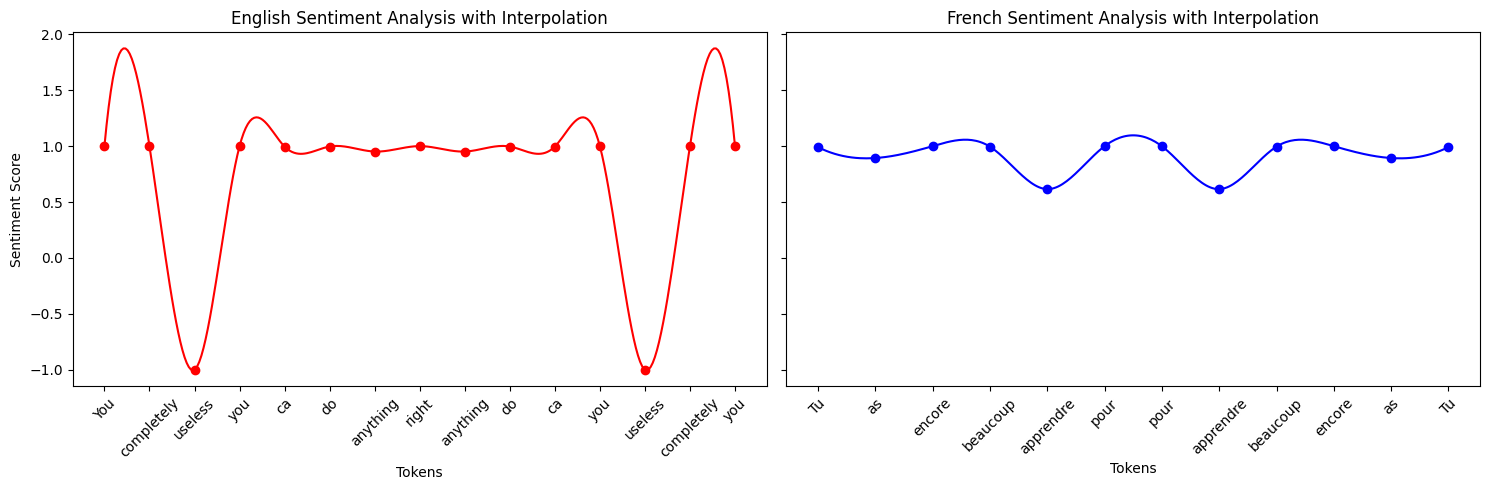

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# Plot the English sentiment scores with interpolation
axes[0].plot(x_english_smooth, y_english_smooth, color='red', label="English Sentiment (Interpolated)")
axes[0].scatter(x_english, english_scores, color='red', label="Original English Scores", marker='o')
axes[0].set_title("English Sentiment Analysis with Interpolation")
axes[0].set_xlabel("Tokens")
axes[0].set_ylabel("Sentiment Score")
axes[0].set_xticks(x_english)
axes[0].set_xticklabels(english_tokens, rotation=45)
#axes[0].grid(True)
#axes[0].legend()
# Plot the French sentiment scores with interpolation
axes[1].plot(x_french_smooth, y_french_smooth, color='blue', label="French Sentiment (Interpolated)")
axes[1].scatter(x_french, french_scores, color='blue', label="Original French Scores", marker='o')
axes[1].set_title("French Sentiment Analysis with Interpolation")
axes[1].set_xlabel("Tokens")
axes[1].set_xticks(x_french)
axes[1].set_xticklabels(french_tokens, rotation=45)
#axes[1].grid(True)
#axes[1].legend()
# Adjust layout
plt.tight_layout()
plt.show()


# Rescaling

In [ ]:
xmin = x_french.min() if x_french.min() < x_english.min() else x_english.min()
xmax = x_french.max() if x_french.max() > x_english.max() else x_english.max()

x_french_smooth = np.linspace(xmin, xmax, 300)
y_french_smooth = make_interp_spline(x_french, french_scores)(x_french_smooth)

x_english_smooth = np.linspace(xmin, xmax, 300)
y_english_smooth = make_interp_spline(x_english, english_scores)(x_english_smooth)


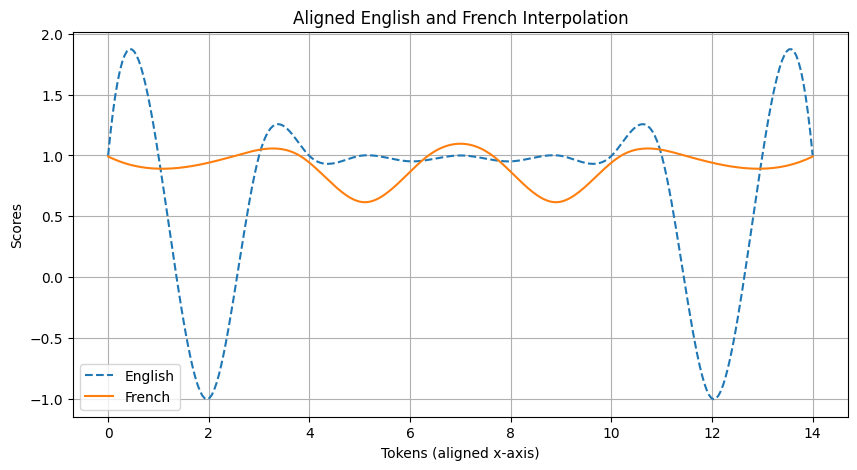

In [ ]:
import numpy as np
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt

# Assuming `english_tokens`, `english_scores`, `french_tokens`, and `french_scores` are defined

# Perform interpolation for English
x_english = np.arange(len(english_tokens))
x_english_smooth = np.linspace(x_english.min(), x_english.max(), 300)
y_english_smooth = make_interp_spline(x_english, english_scores)(x_english_smooth)

# Rescale French x-axis to match English interval
x_french = np.arange(len(french_tokens))
x_french_rescaled = np.linspace(0, len(english_tokens) - 1, len(french_tokens))  # Rescale
x_french_smooth = np.linspace(x_french_rescaled.min(), x_french_rescaled.max(), 300)
y_french_smooth = make_interp_spline(x_french_rescaled, french_scores)(x_french_smooth)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(x_english_smooth, y_english_smooth, label='English', linestyle='--')
plt.plot(x_french_smooth, y_french_smooth, label='French', linestyle='-')
plt.legend()
plt.xlabel('Tokens (aligned x-axis)')
plt.ylabel('Scores')
plt.title('Aligned English and French Interpolation')
plt.grid()
plt.show()


# Time embedding

In [ ]:
ts_list = []
ptcloud_list = []

ts_list.append(y_english_smooth)
ts_list.append(y_french_smooth)
ts_list.append(y_english_smooth)
ts_list.append(y_french_smooth)


# Compute time delay embedding point clouds
ptcloud_list.append(time_delay_embedding(y_english_smooth, d=2, tau=4))
ptcloud_list.append(time_delay_embedding(y_french_smooth, d=2, tau=4))
ptcloud_list.append(time_delay_embedding(y_english_smooth, d=2, tau=4))
ptcloud_list.append(time_delay_embedding(y_french_smooth, d=2, tau=4))


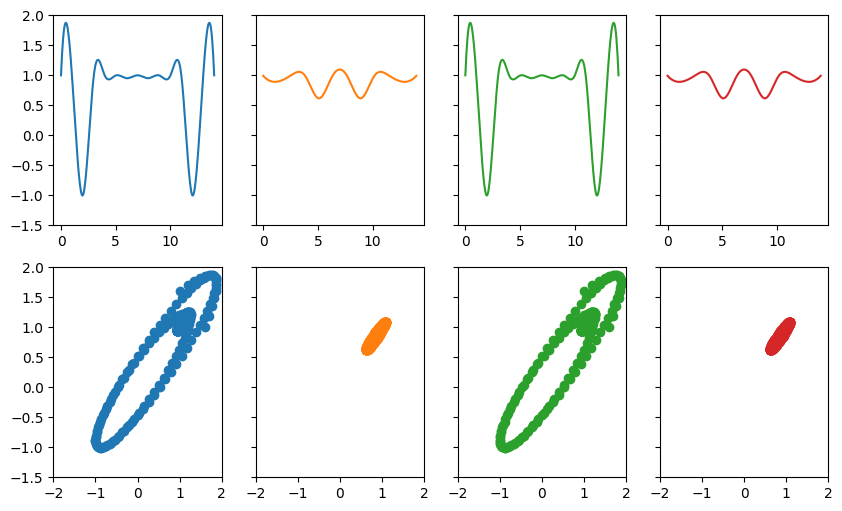

In [ ]:
# Plot time series and corresponding point clouds
t=x_english_smooth
fig, axs = plt.subplots(2, 4 ,sharex = False, sharey=True, figsize=[4*2.5,2*3])
for i in range(4):
    axs[0,i].plot(t,ts_list[i],c='C'+str(i))
    axs[1,i].scatter(ptcloud_list[i][:,0], ptcloud_list[i][:,1],c='C'+str(i))
    axs[1,i].set_xlim([-2, 2]);
    axs[1,i].set_ylim([-1.5,2])

In [ ]:
# Setup zigzag with point clouds
ZZ = PtClouds(ptcloud_list, num_landmarks=25, verbose=True)

Saving fig at  /content/ptcloud2 ...


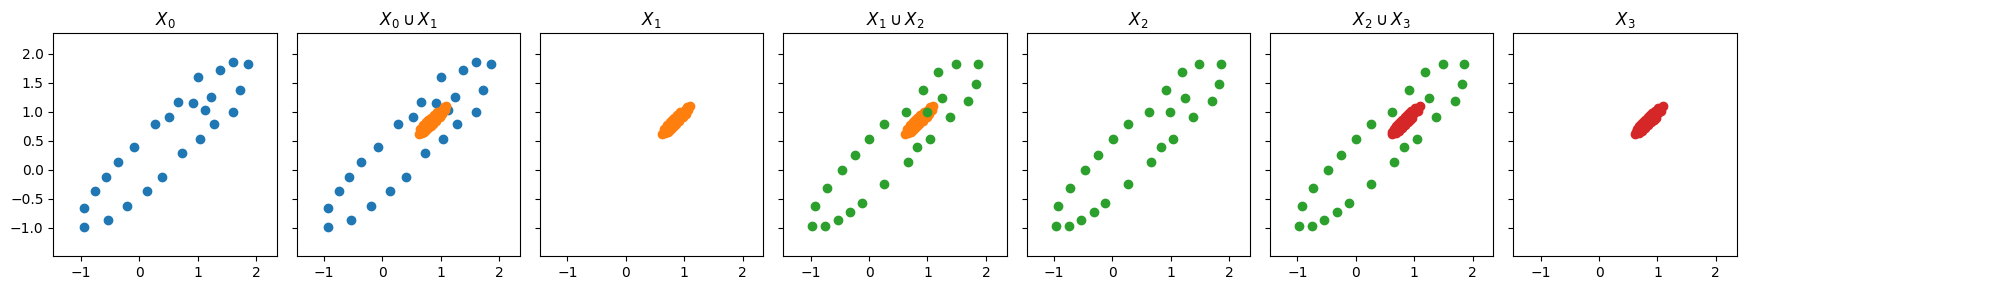

In [ ]:
# Plot zigzag of point clouds
ZZ.plot_ZZ_PtClouds(save=True, savename='/content/ptcloud2')

# ZigZag persistance

In [ ]:
# Compute zigzag persistence
radius=0.1
ZZ.run_Zigzag(r=radius)

Initializing done in 0.00043845176696777344 seconds...
Preprocessing done in 0.022426366806030273 seconds...
Time to build filtration, times:  0.025082826614379883
Time to compute zigzag:  0.0033750534057617188
Total Time:  0.028553485870361328 



Saving fig at  /content/Cplx_1_0.6.svg ...


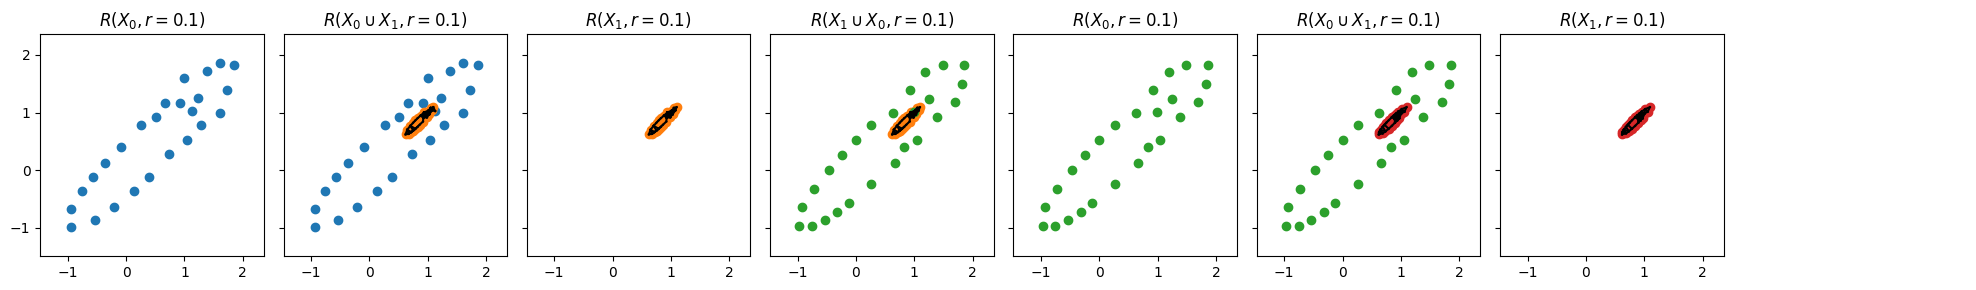

In [ ]:
# Plot zigzag of Rips complexes
location1='/content/Cplx_1_0.6.svg'
ZZ.plot_ZZ_Cplx(r=radius,save=True, savename=location1)

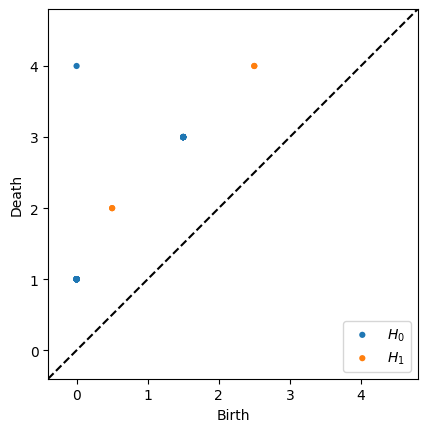

In [ ]:
# Plot zigzag persistence diagram
from persim import plot_diagrams
plot_diagrams(ZZ.zz_dgms)
location2='/content/persistence_diagram_1_0.6.svg'
plt.savefig(location2,format='svg',dpi=500, bbox_inches='tight')


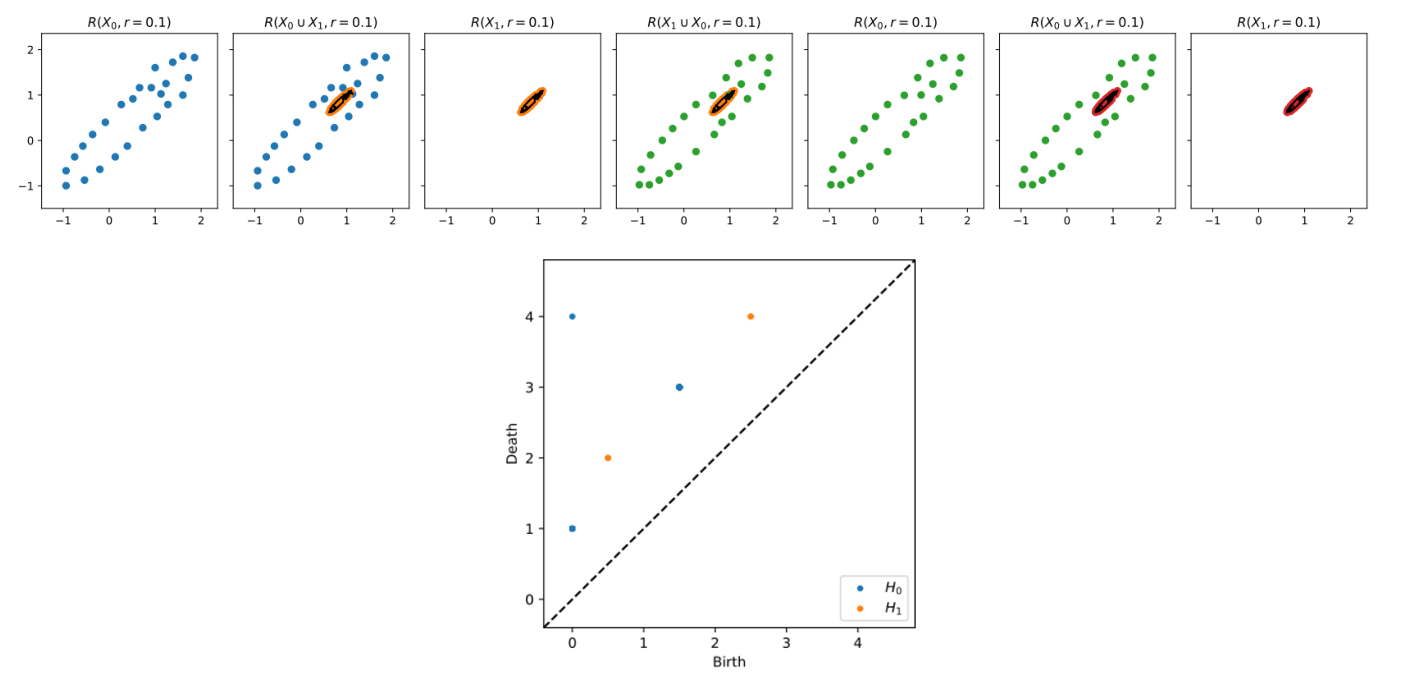

In [ ]:
import matplotlib.pyplot as plt
import cairosvg
from PIL import Image
import numpy as np
from io import BytesIO

# Function to load and convert an SVG file to a NumPy array
def load_svg_as_numpy(svg_file_path, output_size=None):
    png_data = cairosvg.svg2png(url=svg_file_path)
    image = Image.open(BytesIO(png_data))
    if output_size:
        image = image.resize(output_size)
    return np.array(image)

# Load images
top_image = load_svg_as_numpy(location1)
bottom_image = load_svg_as_numpy(location2, output_size=(512, 512))

# Crop the images to exclude the right 10%
crop_width_top = int(top_image.shape[1] * 0.9)
top_image_cropped = top_image[:, :crop_width_top]


# Create figure with reduced height
fig, axes = plt.subplots(
    2, 1, figsize=(14, 12), gridspec_kw={'height_ratios': [3, 1]}
)

# Display cropped images
axes[0].imshow(top_image_cropped)
axes[0].axis('off')

axes[1].imshow(bottom_image)
axes[1].axis('off')

# Adjust layout and spacing
fig.subplots_adjust(hspace=-0.6, left=0, right=1, top=1, bottom=0)
plt.margins(0)

plt.savefig('r=0.1.svg', format='svg',dpi=500, bbox_inches='tight')
plt.show()
